In [2]:
import numpy as np
import torch
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex=True)

import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go

In [3]:
# Config & Setup Details
cfg_batch_size  = 20
cfg_max_epochs  = 10
cfg_num_workers = 2

# Data Config
cfg_data_separator = ","
cfg_data_date_fmt  = "%Y-%m-%d"
cfg_data_url_train = "https://s3.amazonaws.com/mtsu.csci.7850.project/train.csv"
cfg_data_url_test  = "https://s3.amazonaws.com/mtsu.csci.7850.project/test.csv"

# Logger Config
cfg_logger_dir     = "logs"
cfg_logger_name    = "Project"
cfg_logger_version = "data-loader"


In [4]:
# Setup CPU or GPU Device Settings for CUDA
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

Only CPU is available...


In [6]:
# Load Data - Parse the Date Column
df_raw_train = pd.read_csv(cfg_data_url_train, parse_dates=["date"])

print(f"Train Shape: {df_raw_train.shape}")

print(df_raw_train.head())

# Format Date Column to DateTime
df_raw_train['date'] = pd.to_datetime(df_raw_train['date'], format=cfg_data_date_fmt)

df_grouped_date_store = df_raw_train.groupby(['date', 'store'])['sales'].sum().reset_index()
df_grouped_date = df_raw_train.groupby(['date'])['sales'].sum().reset_index()

print(df_grouped_date)
print(df_grouped_date_store)

# Pivot the DataFrame
df_train = df_grouped_date_store.pivot(index='date', columns='store', values='sales')

# Resetting the index
df_train = df_train.reset_index()

# Show the New Table
print(df_train)



Train Shape: (913000, 4)
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
           date  sales
0    2013-01-01  13696
1    2013-01-02  13678
2    2013-01-03  14488
3    2013-01-04  15677
4    2013-01-05  16237
...         ...    ...
1821 2017-12-27  20378
1822 2017-12-28  21885
1823 2017-12-29  23535
1824 2017-12-30  24988
1825 2017-12-31  26420

[1826 rows x 2 columns]
            date  store  sales
0     2013-01-01      1   1316
1     2013-01-01      2   1742
2     2013-01-01      3   1588
3     2013-01-01      4   1423
4     2013-01-01      5   1032
...          ...    ...    ...
18255 2017-12-31      6   2009
18256 2017-12-31      7   1831
18257 2017-12-31      8   3205
18258 2017-12-31      9   2774
18259 2017-12-31     10   2939

[18260 rows x 3 columns]
store       date     1     2     3     4     5     6     7     8     9    10
0

Before filter: (913000, 4)
After filter: (1826, 4)


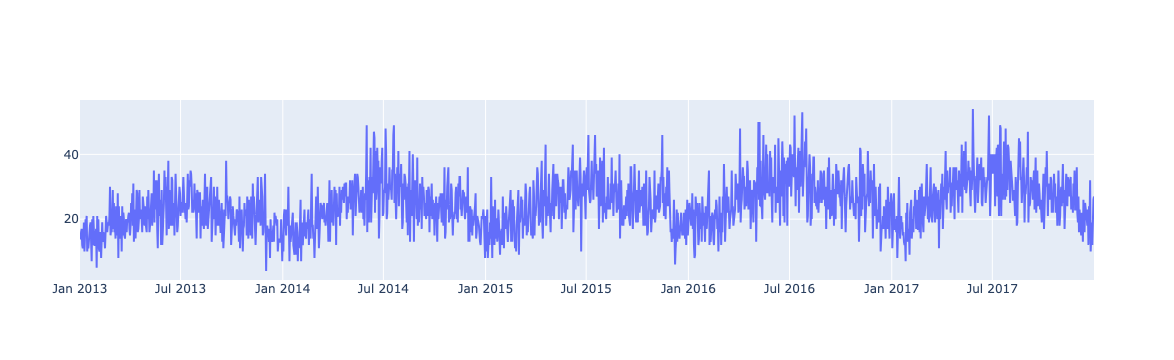

In [12]:
def Time_visualization(data):
    store_item_df = data.copy()
    # First, let us filterout the required data
    store_id = 10   # Some store
    item_id = 1    # Some item
    print('Before filter:', store_item_df.shape)
    store_item_df = store_item_df[store_item_df.store == store_id]
    store_item_df = store_item_df[store_item_df.item == item_id]
    print('After filter:', store_item_df.shape)
    #display(store_item_df.head())

    # Let us plot this now
    store_item_ts_data = [go.Scatter(
        x=store_item_df.date,
        y=store_item_df.sales)]
    py.iplot(store_item_ts_data)
    return store_item_df

store_item_df = Time_visualization(train_df)

In [35]:
# Group by date and sum sales
train_df['date'] = pd.to_datetime(train_df['date'], format=cfg_data_date_fmt)

df_grouped_date_store = train_df.groupby(['date', 'store'])['sales'].sum().reset_index()
df_grouped_date = train_df.groupby(['date'])['sales'].sum().reset_index()

print(train_df)
print(df_grouped_date)
print(df_grouped_date_store)

# Pivot the DataFrame
pivot_df = df_grouped_date_store.pivot(index='date', columns='store', values='sales')

# Resetting the index if you want 'date' as a regular column
pivot_df = pivot_df.reset_index()

print(pivot_df)


             date  store  item  sales
0      2013-01-01      1     1     13
1      2013-01-02      1     1     11
2      2013-01-03      1     1     14
3      2013-01-04      1     1     13
4      2013-01-05      1     1     10
...           ...    ...   ...    ...
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82

[913000 rows x 4 columns]
           date  sales
0    2013-01-01  13696
1    2013-01-02  13678
2    2013-01-03  14488
3    2013-01-04  15677
4    2013-01-05  16237
...         ...    ...
1821 2017-12-27  20378
1822 2017-12-28  21885
1823 2017-12-29  23535
1824 2017-12-30  24988
1825 2017-12-31  26420

[1826 rows x 2 columns]
            date  store  sales
0     2013-01-01      1   1316
1     2013-01-01      2   1742
2     2013-01-01      3   1588
3     2013-01-01      4   1423
4     2013-01-01      5   1032
...          ...    ...    ...

In [28]:
train_df.describe()
#grouped_df.describe()

,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


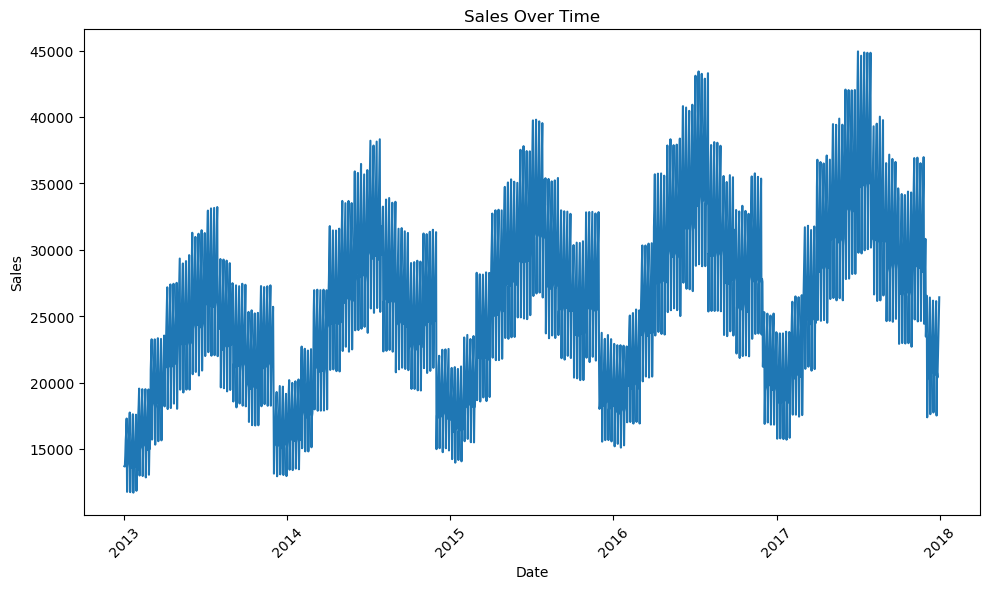

In [30]:

plt.figure(figsize=(10, 6))  # Optional: Sets the figure size
plt.plot(grouped_df['date'], grouped_df['sales'])  # 'o' adds markers to each data point
plt.title('Sales Over Time')  # Optional: Adds a title to the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Sales')  # Label for the y-axis
plt.xticks(rotation=45)  # Optional: Rotates x-axis labels for better readability
plt.tight_layout()  # Optional: Adjusts the plot to ensure everything fits without overlapping
plt.show()